In [339]:
# !pip install vaderSentiment
# !pip install spacy
import nltk
from nltk.corpus import stopwords
import pandas as pd
import pickle
import numpy as np
from nltk import word_tokenize, FreqDist
import string
from os import path
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer as sa
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return (stopwords_removed)

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...','.' ,'``','1','2','3','4','5','6'
                   ,'7','8','9',"'s","'",'’',"n't","'ve","'m"]

sp = spacy.load('en')

In [482]:
with open('userratingsDF.pickle', 'rb') as f:
    dfr = pickle.load(f)

In [342]:
corpus1=dfr['content']
corpus=nltk.Text(dfr['content'])

In [343]:
with open('CategoricalItemDF.pickle', 'rb') as f:
    full = pickle.load(f)

In [344]:
full.sort_values('url',inplace=True)

# Tokenizing and Removing Stop Words & Lemmatizing

In [345]:
#processed_data is a list of lists. each smaller list represents a tokenized
#review where stop words have been removed
processed_data = list(map(process_article, corpus))

In [346]:
#articles_contact is one list containing all words in the tokenized 
#corpus with stopwords removed, can be repeated, not all words unique
articles_concat = []
for article in processed_data:
    articles_concat += article

In [486]:
lemcontent=[]
for review in processed_data:
    words=[]
    sentence=sp(' '.join(review))
    for word in sentence:
        words.append(word.lemma_)
    if words not in lemcontent:
        lemcontent.append(words)

In [348]:
lemwords=[]
words=' '.join(articles_concat)
words=sp(words)
for word in words:
    lemwords.append(word.lemma_)

In [404]:
lemmas_freqdist = FreqDist(lemwords)
# lemmas_freqdist.most_common(200)

In [350]:
maximum_frequncy = max(lemmas_freqdist.values())
weightedic={}
for word in lemmas_freqdist.keys():
    weightedic[word] = (lemmas_freqdist[word]/maximum_frequncy)

In [414]:
sentence_scores = {}
for sent in list(dfr.content):
    for word in sent.split(' '):
        if word in weightedic.keys():
            if len(sent.split(' ')) < 30:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = weightedic[word]
                else:
                    sentence_scores[sent] += weightedic[word]

In [415]:
sent_scores=[]
for s in list(dfr.content):
    for sent,score in zip(sentence_scores.keys(),sentence_scores.values()):
        if sent==s:
            sent_scores.append({'sentence':sent,'score':score})
sentscoredf=pd.DataFrame(sent_scores)

In [422]:
articles_freqdist = FreqDist(articles_concat)
# articles_freqdist.most_common(200)

## Getting Sentiment Scores

In [423]:
dfr.sort_values('url',inplace=True)

In [424]:
new=[]
for p,u,t,us in zip(processed_data,dfr.url,dfr.title,dfr.user):
    new.append({'url':u,'content':' '.join(p),'title':t,'user':us})

In [425]:
len(new)

1685

In [426]:
analyzer = SentimentIntensityAnalyzer()

In [427]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
#     print("{:-<40} {}".format(sentence, str(score)))
    return score['pos']

In [428]:
sentiments=[]
for n in new:
    sentiments.append({'url':n['url'],'tsentiment':sentiment_analyzer_scores(n['title']),'csentiment':sentiment_analyzer_scores(n['content']),'user':n['user']})
sentimentsdf=pd.DataFrame(sentiments)

In [430]:
sentimentsdf.sort_values('url',inplace=True)
# sentimentsdf.drop_duplicates(inplace=True)

In [432]:
avg_sent_by_url=sentimentsdf.groupby('url').mean()
avg_sent_by_url.sort_values('url',inplace=True)

In [463]:
avgsent=[]
for (au,c,t) in zip(avg_sent_by_url.index,avg_sent_by_url['csentiment'],avg_sent_by_url['tsentiment']):
    for u in dfr.url:
        if u==au:
            avgsent.append({'url':au,'content_sent':co,'title_sent':to,'avg_content_sent':c,'avg_title_sent':t})
avgsentdf=pd.DataFrame(avgsent)

In [468]:
avgsentdf.drop_duplicates(inplace=True)
# avgsentdf.reset_index(inplace=True)
avgsentdf.drop(columns=['content_sent','title_sent'],inplace=True)
len(avgsentdf)

514

In [470]:
avgt=[]
avgc=[]
for u in dfr.url:
    for (ua,t,c) in zip(avgsentdf.url,avgsentdf.avg_title_sent,avgsentdf.avg_content_sent):
        if u==ua:
#             avgt.append({'url':u,'avg_title_sent':t,'avg_content_sent':c})
            avgt.append(t)
            avgc.append(c)

In [471]:
df1=dfr
df1.drop_duplicates(inplace=True)
df1['average_content_sentiment']=avgc
df1['average_title_sentiment']=avgt
df1['content_sentiment']=list(sentimentsdf['csentiment'])
df1['title_sentiment']=list(sentimentsdf['tsentiment'])
# df1['processed_content']=lemcontent

In [472]:
df1

,content,date,rating,title,url,user,content_sentiment,title_sentiment,average_content_sentiment,average_title_sentiment
1585,i have used this product for 4 years. easy to ...,2012-01-30,5,Years,10236357,kimber,0.213,0.000,0.30640,0.507400
1588,"the best eye creme ever tried, it delivers res...",2005-09-22,5,simply the best,10236357,george,0.325,0.677,0.30640,0.507400
1587,the cream was easy to use and did not feel gre...,2007-12-19,5,Great Results. Loved It.,10236357,mike,0.425,0.800,0.30640,0.507400
1586,"i didn't have any wrinkles around my eyes, but...",2010-02-05,5,It's worth the money,10236357,adrian,0.320,0.388,0.30640,0.507400
1584,it keeps your eye area moisturizer without bei...,2014-04-21,5,Great eye product,10236357,westtexas,0.249,0.672,0.30640,0.507400
2753,i am surprised that jurlique did not name this...,2012-09-27,5,Comforting,10305907,marvymds,0.259,1.000,0.38100,0.753000
2752,it seems like such a small tube but fortunatel...,2014-03-10,4,Mattifying; Great for combination skin,10305907,trixie,0.503,0.506,0.38100,0.753000
2167,this is the best toner i have ever used! it is...,2006-08-04,5,Love it!,10305956,sandi,0.326,0.818,0.24850,0.378000
2166,"this was my first purchse with skinstore, and ...",2008-01-01,5,"Bright, Beautiful and Bearly there",10305956,"cara bryant, newman, western australia",0.248,0.694,0.24850,0.378000
2165,just read alcohol is a terrible ingrediant for...,2008-03-01,1,Alcohol?!,10305956,confused,0.000,0.000,0.24850,0.378000


In [473]:
df1.reset_index(inplace=True)
df1.drop(columns='index',inplace=True)
df1 # YES!

,content,date,rating,title,url,user,content_sentiment,title_sentiment,average_content_sentiment,average_title_sentiment
0,i have used this product for 4 years. easy to ...,2012-01-30,5,Years,10236357,kimber,0.213,0.000,0.30640,0.507400
1,"the best eye creme ever tried, it delivers res...",2005-09-22,5,simply the best,10236357,george,0.325,0.677,0.30640,0.507400
2,the cream was easy to use and did not feel gre...,2007-12-19,5,Great Results. Loved It.,10236357,mike,0.425,0.800,0.30640,0.507400
3,"i didn't have any wrinkles around my eyes, but...",2010-02-05,5,It's worth the money,10236357,adrian,0.320,0.388,0.30640,0.507400
4,it keeps your eye area moisturizer without bei...,2014-04-21,5,Great eye product,10236357,westtexas,0.249,0.672,0.30640,0.507400
5,i am surprised that jurlique did not name this...,2012-09-27,5,Comforting,10305907,marvymds,0.259,1.000,0.38100,0.753000
6,it seems like such a small tube but fortunatel...,2014-03-10,4,Mattifying; Great for combination skin,10305907,trixie,0.503,0.506,0.38100,0.753000
7,this is the best toner i have ever used! it is...,2006-08-04,5,Love it!,10305956,sandi,0.326,0.818,0.24850,0.378000
8,"this was my first purchse with skinstore, and ...",2008-01-01,5,"Bright, Beautiful and Bearly there",10305956,"cara bryant, newman, western australia",0.248,0.694,0.24850,0.378000
9,just read alcohol is a terrible ingrediant for...,2008-03-01,1,Alcohol?!,10305956,confused,0.000,0.000,0.24850,0.378000


In [474]:
with open('_SENT&RATINGDF.pickle', 'wb') as f:
    pickle.dump(df1, f, pickle.HIGHEST_PROTOCOL)

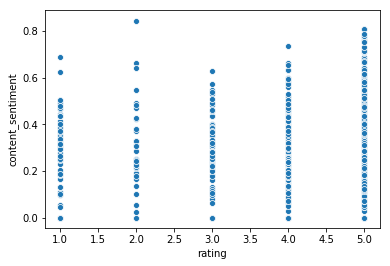

In [475]:
import seaborn as sns
sns.scatterplot(x='rating',y='content_sentiment',data=df1)

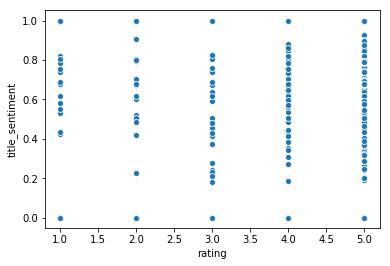

In [476]:
sns.scatterplot(x='rating',y='title_sentiment',data=df1)

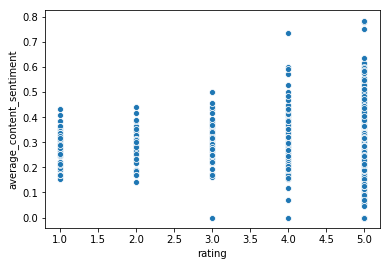

In [477]:
sns.scatterplot(x='rating',y='average_content_sentiment',data=df1)

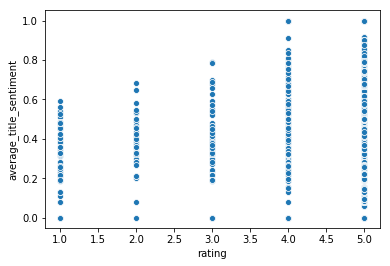

In [478]:
sns.scatterplot(x='rating',y='average_title_sentiment',data=df1)

# Trying TFIDF: not sure why we would need this

In [160]:
# tfidf = vectorizer.fit_transform(corpus)

In [162]:
# tfidf.shape

(3258, 5274)

In [164]:
# non_zero_cols = tfidf.nnz / float(tfidf.shape[0])
# print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

# percent_sparse = 1 - (non_zero_cols / float(tfidf.shape[1]))
# print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 42.258747697974215
Percentage of columns containing 0: 0.9919873440087269


# Some NLTK EDA

In [30]:
tokens=[]
for r in dfr.content:
    tokens.append(nltk.word_tokenize(r.lower()))

In [54]:
alltokensr=[]
for t in tokens:
    string=[]
    for word in t:
        if word not in stopwords_list:
            string.append(word)
    alltokensr.append(string)

In [55]:
dfr['tokens']=alltokensr

In [56]:
allvocab=set()
for comment in alltokensr:
    allvocab.update(comment)
len(allvocab)

5857

In [57]:
articles_concat = []
for article in alltokensr:
    articles_concat += article

In [58]:
from wordcloud import WordCloud

In [491]:
def plot_wordcloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

## Whole Corpus Word Cloud

In [492]:
wordcloud = WordCloud().generate(str(corpus[7:]))

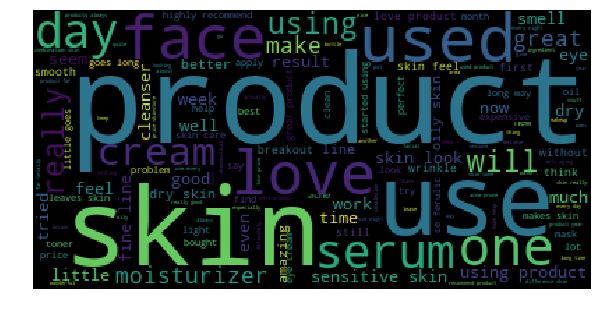

In [493]:
plot_wordcloud(wordcloud)

## Processed Corpus Word Cloud 

In [494]:
lemwords=[]
words=' '.join(articles_concat)
words=sp(words)
for word in words:
    lemwords.append(word.lemma_)

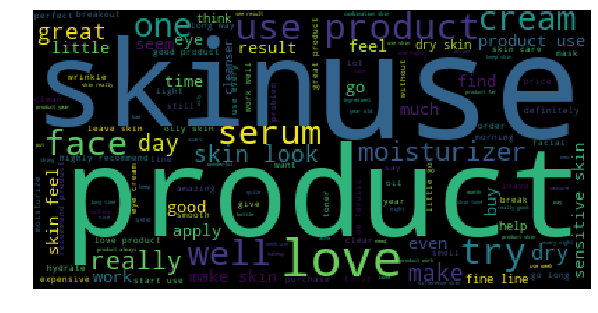

In [495]:
al=' '.join(lemwords)
wordcloud = WordCloud().generate(al)
plot_wordcloud(wordcloud)